<a href="https://colab.research.google.com/github/Hoang-it/orhcid_classification/blob/main/sof/sof_fast_rcnn_resnet50_fpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import torch
from PIL import Image

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms):
    self.root = root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
  def __getitem__(self, idx):
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = Image.open(img_path).convert("RGB")

    mask = Image.open(mask_path)
    mask = np.array(mask)
    obj_ids = np.unique(mask)
    obj_ids = obj_ids[1:]

    masks = mask == obj_ids[:, None, None]

    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    iscrowd = torch.zeross((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)
    
    return img, target

  def __len__(self):
    return len(self.imgs)

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


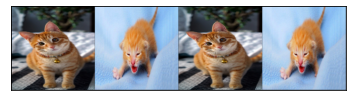

In [19]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
from torchvision import transforms


p = transforms.Compose([transforms.Scale((1000,1000))])

dog1_int = p(read_image('/content/cat-1.jpg'))
dog2_int = p(read_image('/content/cat.jpg'))

grid = make_grid([dog1_int, dog2_int, dog1_int, dog2_int])
show(grid)

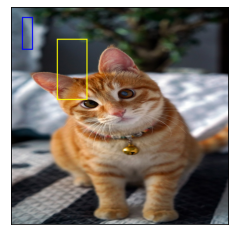

In [20]:
from torchvision.utils import draw_bounding_boxes


boxes = torch.tensor([[50, 50, 100, 200], [210, 150, 350, 430]], dtype=torch.float)
colors = ["blue", "yellow"]
result = draw_bounding_boxes(dog1_int, boxes, colors=colors, width=5)
show(result)

In [21]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype


batch_int = torch.stack([dog1_int, dog2_int])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
model = model.eval()

outputs = model(batch)
print(outputs)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


[{'boxes': tensor([[1.1389e+02, 1.8212e+02, 9.3201e+02, 9.7665e+02],
        [3.2930e-02, 1.0645e+01, 1.1530e+02, 3.1130e+02],
        [1.5269e+01, 5.3646e+02, 1.0000e+03, 1.0000e+03],
        [5.0393e+01, 2.0763e+02, 7.5170e+02, 6.8189e+02],
        [6.7011e+02, 2.9519e+02, 9.9678e+02, 6.1740e+02],
        [6.8572e+02, 2.9546e+02, 9.8333e+02, 5.9437e+02],
        [6.9209e+02, 2.9492e+02, 9.9828e+02, 5.9612e+02]],
       grad_fn=<StackBackward>), 'labels': tensor([17,  1, 81, 17, 81, 51, 48]), 'scores': tensor([0.9964, 0.2043, 0.1446, 0.1304, 0.1178, 0.0899, 0.0722],
       grad_fn=<IndexBackward>)}, {'boxes': tensor([[ 227.4943,   92.1416,  748.6864,  909.2228],
        [  26.9172,    0.0000,  924.0447,  954.8237],
        [ 618.7528,  279.0459,  998.3895,  970.5319],
        [  44.3292,    0.0000,  913.8972,  932.8955],
        [ 139.5236,   53.4016,  801.9089,  937.2318],
        [ 539.0284,  364.4441, 1000.0000,  979.3326],
        [ 624.5387,  289.7592, 1000.0000,  976.4697],
    

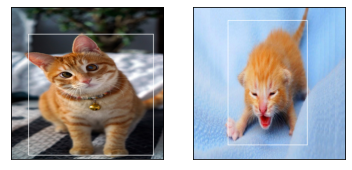

In [22]:
score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for dog_int, output in zip(batch_int, outputs)
]
show(dogs_with_boxes)

In [23]:
from torchvision.models.segmentation import fcn_resnet50


model = fcn_resnet50(pretrained=True, progress=False)
model = model.eval()

normalized_batch = F.normalize(batch, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
output = model(normalized_batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([2, 21, 1000, 1000]) -5.759698390960693 12.89499568939209


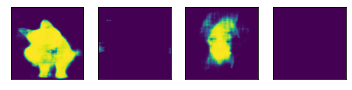

In [25]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

dog_and_boat_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(batch.shape[0])
    for cls in ('cat', 'boat')
]

show(dog_and_boat_masks)

shape = torch.Size([2, 1000, 1000]), dtype = torch.bool


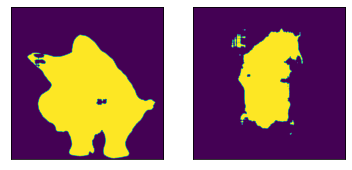

In [27]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['cat'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")
show([m.float() for m in boolean_dog_masks])

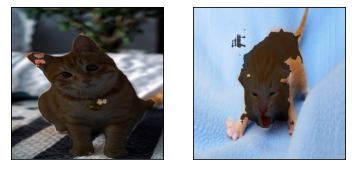

In [28]:
from torchvision.utils import draw_segmentation_masks

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(batch_int, boolean_dog_masks)
]
show(dogs_with_masks)

dog1_masks shape = torch.Size([21, 1000, 1000]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 1000, 1000]), dtype = torch.bool


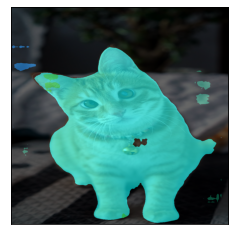

In [29]:
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = draw_segmentation_masks(dog1_int, masks=dog1_all_classes_masks, alpha=.6)
show(dog_with_all_masks)

In [112]:
from typing import Union, Optional, List, Tuple, Text, BinaryIO
import pathlib
import torch
import math
import warnings
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageColor

def get_segmentation_object(
    image: torch.Tensor,
    masks: torch.Tensor,
    alpha: float = 0.8,
    colors: Optional[List[Union[str, Tuple[int, int, int]]]] = None,
) -> torch.Tensor:

    """
    Draws segmentation masks on given RGB image.
    The values of the input image should be uint8 between 0 and 255.

    Args:
        image (Tensor): Tensor of shape (3, H, W) and dtype uint8.
        masks (Tensor): Tensor of shape (num_masks, H, W) or (H, W) and dtype bool.
        alpha (float): Float number between 0 and 1 denoting the transparency of the masks.
            0 means full transparency, 1 means no transparency.
        colors (list or None): List containing the colors of the masks. The colors can
            be represented as PIL strings e.g. "red" or "#FF00FF", or as RGB tuples e.g. ``(240, 10, 157)``.
            When ``masks`` has a single entry of shape (H, W), you can pass a single color instead of a list
            with one element. By default, random colors are generated for each mask.

    Returns:
        img (Tensor[C, H, W]): Image Tensor, with segmentation masks drawn on top.
    """

    if not isinstance(image, torch.Tensor):
        raise TypeError(f"The image must be a tensor, got {type(image)}")
    elif image.dtype != torch.uint8:
        raise ValueError(f"The image dtype must be uint8, got {image.dtype}")
    elif image.dim() != 3:
        raise ValueError("Pass individual images, not batches")
    elif image.size()[0] != 3:
        raise ValueError("Pass an RGB image. Other Image formats are not supported")
    if masks.ndim == 2:
        masks = masks[None, :, :]
    if masks.ndim != 3:
        raise ValueError("masks must be of shape (H, W) or (batch_size, H, W)")
    if masks.dtype != torch.bool:
        raise ValueError(f"The masks must be of dtype bool. Got {masks.dtype}")
    if masks.shape[-2:] != image.shape[-2:]:
        raise ValueError("The image and the masks must have the same height and width")

    num_masks = masks.size()[0]
    if colors is not None and num_masks > len(colors):
        raise ValueError(f"There are more masks ({num_masks}) than colors ({len(colors)})")

    if colors is None:
        colors = _generate_color_palette(num_masks)

    if not isinstance(colors, list):
        colors = [colors]
    if not isinstance(colors[0], (tuple, str)):
        raise ValueError("colors must be a tuple or a string, or a list thereof")
    if isinstance(colors[0], tuple) and len(colors[0]) != 3:
        raise ValueError("It seems that you passed a tuple of colors instead of a list of colors")

    out_dtype = torch.uint8

    colors_ = []
    for color in colors:
        if isinstance(color, str):
            color = ImageColor.getrgb(color)
        color = torch.tensor(color, dtype=out_dtype)
        colors_.append(color)

    img_to_draw = image.detach().clone()
    # print(len(tuple(zip(masks, colors_))))
    # show(img_to_draw)
    # TODO: There might be a way to vectorize this
    for mask, color in zip(masks, colors_):
        # print(mask)
        # return
        img_to_draw[:, mask] = color[:, None]

    # print(type(image))
    # print(type(img_to_draw))

    image = transforms.ToPILImage()(image)
    img_to_draw = transforms.ToPILImage()(img_to_draw)

    # Crop object
    # print(type(image))
    # print(type(img_to_draw))

    image.show()
    img_to_draw.show()

    d1 = image.getdata()
    d2 = img_to_draw.getdata()

    colors = img_to_draw.convert('RGB').getcolors() #this converts the mode to RGB
    # print(colors)

    new_image = []
    for index, item in enumerate(d2):
        
        # change all white (also shades of whites)
        # pixels to yellow
        if item[0] == 8:
            new_image.append(d1[index])

            # print(index)
        else:
            new_image.append((0, 0, 0))
            
            
              
    # update image data
    image.putdata(new_image)

    # out = image * (1 - alpha) + img_to_draw * alpha
    # return out.to(out_dtype)
    return image
    

def _generate_color_palette(num_masks):
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    return [tuple((i * palette) % 255) for i in range(num_masks)]

In [113]:
num_classes = normalized_masks.shape[1]
dog1_masks = normalized_masks[0]
class_dim = 0
dog1_all_classes_masks = dog1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"dog1_masks shape = {dog1_masks.shape}, dtype = {dog1_masks.dtype}")
print(f"dog1_all_classes_masks = {dog1_all_classes_masks.shape}, dtype = {dog1_all_classes_masks.dtype}")

dog_with_all_masks = get_segmentation_object(dog1_int, masks=dog1_all_classes_masks, alpha=.0)
dog_with_all_masks.save("output.jpg")

dog1_masks shape = torch.Size([21, 1000, 1000]), dtype = torch.float32
dog1_all_classes_masks = torch.Size([21, 1000, 1000]), dtype = torch.bool


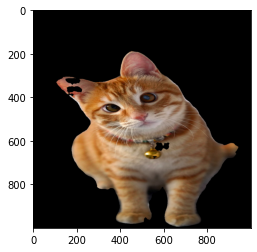

In [114]:
from matplotlib.pyplot import imshow
imshow(np.asarray(dog_with_all_masks))
